In [1]:
import os
import dask
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from streamjoy import stream, wrap_matplotlib
from viztool import FormatScalarFormatter, pcolor_center, pcolor_limits
from dask.distributed import LocalCluster, Client
from dask_jobqueue import PBSCluster
# from dask.distributed import Client
from xgcm import Grid
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib widget

In [2]:
# resources = [f'./frame_{i:05d}.png' for i in range(315)]
# b3d = stream(resources, uri='f11_Q000_W000_D000_St0_b3d.mp4')  # .gif and .mp4 supported

In [3]:
def get_layer_mean(obj, zbot=-60, ztop=None):
    # print(obj.sizes)
    lm = obj.sel(zC=slice(zbot,ztop)).mean(['xC','yC','zC'])
    return lm

In [2]:
@wrap_matplotlib()
def plot_xz(da, timeTf, **plot_kwargs):
    plt.rcParams['axes.labelsize'] = 8
    plt.rcParams['savefig.bbox'] = 'tight'
    var, b = da
    subplot_kw = dict(facecolor='gray')
    bkw = dict(linewidths=0.3, colors='xkcd:almost black')
    fig, ax = plt.subplots(figsize=(3, 2), subplot_kw=subplot_kw, dpi=300, constrained_layout=True)
    im = var.plot.pcolormesh(ax=ax, add_colorbar=False, add_labels=False, **plot_kwargs)
    # blines = np.concatenate([np.arange(0,1,0.2), np.arange(0.85,2.6,0.05)])*1e-4
    b.plot.contour(ax=ax, levels=50, **bkw)
    ax.set_title(var.long_name+' ['+var.units+']', fontsize=6)
    ax.set_aspect(8)
    ax.set_xlabel(f'x [km]')
    ax.set_ylabel(f'z [km]')
    ax.tick_params(axis='both', which='major', labelsize=6)
    # t_str = rf'T$_{{inertial}}: $ {timeTf:5.1f}'
    t_str = rf'Days: {timeTf*(2*np.pi/1e-4/3600/24):4.1f}'
    ax.text(0.01, 0.99, t_str, ha='left', va='top', fontsize=5, transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0'))
    cbar = plt.colorbar(im, ax=ax, shrink=0.3, aspect=25, pad=0.1)
    cbar.ax.tick_params(labelsize=6) 
    return fig

@wrap_matplotlib()
def plot_xy(da, timeTf, **plot_kwargs):
    plt.rcParams['axes.labelsize'] = 8
    plt.rcParams['savefig.bbox'] = 'tight'
    var, b = da
    xvar, yvar = sorted(var.dims)
    xb, yb = sorted(b.dims)
    # subplot_kw = dict(facecolor='gray')
    bkw = dict(linewidths=0.1, colors='xkcd:almost black')
    fig = plt.figure(figsize=(2.5, 5), dpi=300, constrained_layout=True)#subplot_kw=subplot_kw, 
    ax = plt.gca()
    im = ax.pcolormesh(var[xvar], var[yvar], var, **plot_kwargs)
    # blines = np.arange(-2,3)*1e-2#np.arange(-6,14,2)*1e-6
    ax.contour(b[xb], b[yb], b, levels=5, **bkw)#blines,
    ax.set_title(var.long_name + ' [' + var.units + ']', fontsize=6)
    ax.set_aspect('equal')
    ax.set_xlabel(f'x [km]')
    ax.set_ylabel(f'y [km]')
    ax.tick_params(axis='both', which='major', labelsize=6)
    # t_str = rf'T$_{{inertial}}: $ {timeTf:5.1f}'
    t_str = rf'Days: {timeTf*(2*np.pi/1e-4/3600/24):4.1f}'
    ax.text(0.01, 0.99, t_str, ha='left', va='top', fontsize=5, transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0'))
    cbar = plt.colorbar(im, ax=ax, shrink=0.3, aspect=40, pad=0.1, extend='both')
    cbar.ax.tick_params(labelsize=6) 
    return fig

In [ ]:
# @wrap_matplotlib()
def plot_xyz3d(ds, timeTf, **kwargs):
    # plt.rcParams['axes.labelsize'] = 6
    from mpl_toolkits.mplot3d.axis3d import Axis
    if not hasattr(Axis, '_get_coord_info_old'):
        def _get_coord_info_new(self, renderer):
            mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
            mins += deltas / 4
            maxs -= deltas / 4
            return mins, maxs, centers, deltas, tc, highs
        Axis._get_coord_info_old = Axis._get_coord_info
        Axis._get_coord_info = _get_coord_info_new

    top, south, east = ds
    var = kwargs.pop('var', 'b')
    xvar, yvar, zvar = sorted(set(top[var].dims + east[var].dims))
    xb, yb, zb = sorted(set(top.b.dims + east.b.dims))

    cticks = kwargs.pop('cticks')
    cticks_nsd = kwargs.pop('cticks_nsd')
    clabel_pad = kwargs.pop('clabel_pad')
    var_label = kwargs.pop('var_label')
    sci_notation = kwargs.pop('sci_notation')
    xmin, xmax = np.around(south[xvar].min().data), np.around(south[xvar].max().data)
    ymin, ymax = np.around(east[yvar].min().data), np.around(east[yvar].max().data)
    zmin, zmax = np.around(east[zvar].min().data), np.around(top[zvar].data)

    # bmin, bmax = top.b.min(), top.b.max()
    # cref = np.around(((bmin+bmax)/2+0.2e-4)/2.1e-4, 2)
    # colorlist = ['xkcd:navy', 'xkcd:cerulean', 'xkcd:sky', 'xkcd:white', 'xkcd:coral', 'xkcd:deep red']
    # nodes = [0.0, cref-0.16, cref-0.08, cref, cref+0.08, 1.0]
    # cmap = LinearSegmentedColormap.from_list('buoyancy', list(zip(nodes, colorlist)))
    # kwargs.update(dict(cmap=cmap))

    if top.attrs['M²'] == 9e-8:
        # blines = np.arange(0,2.6,0.1)*1e-3
        blines = np.concatenate([np.arange(0,1.5,0.1), np.arange(1.43,2.6,0.03)])*1e-3
    elif top.attrs['M²'] == 2.7e-7:
        blines = np.concatenate([np.arange(0,1.25,0.08), np.arange(1.25,2.6,0.008)])*1e-2
    subplot_kw = dict(projection='3d', computed_zorder=False)
    bkw = dict(levels=blines, linewidths=0, colors='xkcd:almost black')
    edges_kw = dict(color='xkcd:charcoal', linewidth=1, zorder=2)

    plt.close()
    fig = plt.figure(figsize=(5,4.8), layout='constrained')#dpi=300)
    # gs = gridspec.GridSpec(10, 80, figure=fig)
    # ax = fig.add_subplot(gs[:, :], **subplot_kw)
    ax = fig.add_subplot(111, **subplot_kw)
    im = ax.contourf(top[xvar], top[yvar], top[var], zdir='z', offset=top[zvar], **kwargs)
    ax.contour(top[xb], top[yb], top.b, zdir='z', offset=top[zb], **bkw)

    bkw.update(linewidths=0.2) #in place
    X, Z = np.meshgrid(south[xvar], south[zvar])
    ax.contourf(X, south[var], Z, zdir='y', offset=south[yvar], **kwargs)
    X, Z = np.meshgrid(south[xb], south[zb])
    ax.contour(X, south.b, Z, zdir='y', offset=south[yb], **bkw)

    Y, Z = np.meshgrid(east[yvar], east[zvar])
    ax.contourf(east[var], Y, Z, zdir='x', offset=east[xvar], **kwargs)
    Y, Z = np.meshgrid(east[yb], east[zb])
    ax.contour(east.b, Y, Z, zdir='x', offset=east[xb], **bkw)

    #cax = fig.add_subplot(gs[3:7,79:])
    cbar = fig.colorbar(im, ax=ax, ticks=cticks, shrink=0.38, aspect=38, # cax=cax, 
                        format=FormatScalarFormatter(f'%.{cticks_nsd}f'))
    cbar.set_label(var_label, labelpad=clabel_pad, fontsize=9)
    cbar.ax.tick_params(labelsize=7, length=1.5)
    if sci_notation:
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.get_yaxis().get_offset_text().set_visible(False)
        exponent_axis = np.floor(np.log10(max(cbar.ax.get_yticks()))).astype(int)
        cbar.ax.annotate(r'$\times$10$^{%i}$'%(exponent_axis), fontsize=7,
                         xy=(-0.2, 1.08), xycoords='axes fraction')

    ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
    ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])
    ax.set(
           # zticks=[zmax, -60, -120],
           # xticks=[-400, -200, 0, 200, 400],
           # yticks=[0, 200],
           # yticks=[100, 300, 500, 700, 900],
           xlim=[xmin, xmax],
           ylim=[ymin, ymax],
           zlim=[zmin, zmax])
    # ax.set_xlabel('X [m]', labelpad=5)
    # ax.set_ylabel('Y [m]', labelpad=0)
    # ax.set_zlabel('Z [m]', labelpad=0)
    # ax.tick_params(axis='x', which='major', labelsize=5, pad=1, length=1)
    # ax.tick_params(axis='y', which='major', labelsize=5, pad=1, length=0)
    # ax.tick_params(axis='z', which='major', labelsize=5, pad=1, length=0)
    
    # ax.view_init(40, -53, 0)
    ax.view_init(35, -65, 0)
    ax.set_box_aspect((1, ymax/(xmax-xmin)*1.2, ymax/(xmax-xmin)*1.2), zoom=1)
    # ax.set_title(rf'$T_{{inertial}}$ = {timeTf:.2f}', y=0.999, x=0.7, fontsize=6)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    return fig

In [26]:
def get_bt_ufunc(b, x, dbdx=-3e-8):
    bt = b + dbdx*x
    return bt

In [16]:
@wrap_matplotlib()
def plot_3Dbox_surface(dsf, cname=None):
    plt.rcParams['axes.labelsize'] = 8
    plt.rcParams['savefig.bbox'] = 'tight'
    top, south, east = dsf
    time = top.timeTf
    z_top_slice = top.zC
    y_south_slice = south.yC
    x_east_slice = east.xC

    if vname == 'PV':
        cmap = 'RdBu_r'
        cticks = np.arange(-2e-10,3e-10,1e-10)
        clabel_pad = -50
        vmin, vmax = -2.5e-10, 2.5e-10
        var_label = r'Ertel PV'
        var_extend = 'both'
        sci_notation = True
        var_plt = 'PV'
        coords = 'F'
    else:
        coords = 'C'
        if vname == 'b':
            colorlist = ['xkcd:navy', 'xkcd:cerulean', 'xkcd:sky', 'xkcd:white', 'xkcd:coral', 'xkcd:deep red']
            nodes = [0.0, 0.7, 0.78, 0.82, 0.9, 1.0]
            cmap = LinearSegmentedColormap.from_list('buoyancy', list(zip(nodes, colorlist)))
            cticks = np.arange(0,2,0.2)*1e-4
            clabel_pad = -45
            vmin, vmax = -2e-5, 1.9e-4
            var_label = r'Buoyancy [m s$^{-2}$]'
            var_extend = 'max'
            sci_notation = True
            var_plt = 'bt'
        elif vname == 'c':
            # top['logc']   =   np.log10(top.c.clip(1e-6,1)).squeeze().transpose('yC','xC',...)
            # south['logc'] = np.log10(south.c.clip(1e-6,1)).squeeze().transpose('xC','zC',...)
            # east['logc']  =  np.log10(east.c.clip(1e-6,1)).squeeze().transpose('yC','zC',...)
            cmap = 'ocean_r'
            cticks = np.arange(0,1.2,0.2)#np.arange(-2,0.5,0.5)
            clabel_pad = -40#-50
            vmin, vmax = 0, 1#-2, 0
            var_label = 'c'#r'$\log_{10}(c)$'
            var_extend = 'max'#'min'
            sci_notation = False
            var_plt = 'c'#'logc'
        elif vname == 'u':
            cmap = 'RdBu_r'
            cticks = np.arange(-0.03,0.04,0.01)
            clabel_pad = -50
            vmin, vmax = -0.038, 0.038
            var_label = r'u [m s$^{-1}$]'
            var_extend = 'both'
            sci_notation = True
            var_plt = 'u'
        elif vname == 'eps':
            cmap = 'Reds'
            cticks = np.arange(-9,-6,1)
            clabel_pad = -50
            vmin, vmax = -9, -7
            var_label = r'Dissipation rate $\log_{10}(\epsilon)$'
            var_extend = 'min'
            sci_notation = False
            var_plt = 'logeps'

    # top = dsf[var_sel].sel(zC=[zlev], method='nearest')
    
    # south = dsf[var_sel].isel(yC=[0]).sel(zC=slice(None,z_top_slice))
    
    # east = dsf[var_sel].isel(xC=[-1]).sel(zC=slice(None,z_top_slice))

    if coords == 'F':
        top = top.sel(zF=[zlev], method='nearest')
        zF_top_slice = top.zF[0]
        south = south.isel(yF=[0]).sel(zF=slice(None,zF_top_slice))
        yF_south_slice = south.yF[0]
        east = east.isel(xF=[-1]).sel(zF=slice(None,zF_top_slice))
        xF_east_slice = east.xF[0]
        XF, YF, ZF = np.meshgrid(top.xF, top.yF, east.zF)

    # total buoyancy
    # dsf['bt']   = (-dsf.attrs['M²'] * dsf.xC +   dsf.b).squeeze().transpose('yC','xC',...)
    # south['bt'] = (-dsf.attrs['M²'] * south.xC + south.b).squeeze().transpose('xC','zC',...)
    # east['bt']  = (-dsf.attrs['M²'] * east.xC +  east.b).squeeze().transpose('yC','zC',...)

    if vname == 'eps':
        varT =   np.log10(top.eps)
        # varS = np.log10(south.eps).squeeze().transpose('xC','zC',...)
        # varE =  np.log10(east.eps).squeeze().transpose('yC','zC',...)
    else:
        varT = top[var_plt]
        varS = south[var_plt]
        varE = east[var_plt]

    # surface wind
    taum = int(cname[10:13])/1e3
    taud = int(cname[15:18])
    if cname[14] == 'O':
        temporal_wind = np.sin(2*np.pi*np.maximum((time - 6), 0))
    else:
        cos_ramp = (1 - np.cos(np.pi*np.maximum((time - 6), 0) / np.sqrt(2))) / 2
        if time < (6+np.sqrt(2)):
            temporal_wind = cos_ramp
        else:
            temporal_wind = 1
    taux = np.cos(taud/180*np.pi)*taum*temporal_wind
    tauy = np.sin(taud/180*np.pi)*taum*temporal_wind

    # limits and contour values
    blines = np.concatenate([np.arange(0,1.4,0.2), np.arange(1.3,2.6,0.04)])*1e-4
    xmin, xmax = -500, 500
    ymin, ymax = 0, 1000
    zmin, zmax = -140, z_top_slice.data

    Ckw = {'vmin': vmin,
           'vmax': vmax,
           'extend': var_extend,
           'levels': np.linspace(vmin, vmax, 256*2),
           'cmap': cmap
          }
    Lkw = {'linewidths': 0.2,
           'colors': 'xkcd:almost black'
          }
    Lkwt = {'linewidths': 0.05,
            'colors': 'xkcd:almost black'
           }
    edges_kw = {'color': 'xkcd:charcoal',
                'linewidth': 1,
                'zorder': 2
               }

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
    xroll = 0
    if coords == 'F':
        Ct = ax.contourf(XF[:, :, -1], YF[:, :, -1], varT.roll(xF=xroll), zdir='z', offset=zF_top_slice, **Ckw)
        # Cs = ax.contourf(XF[0, :, :], varS.roll(xF=xroll), ZF[0, :, :], zdir='y', offset=yF_south_slice, **Ckw)
        # Ce = ax.contourf(varE, YF[:, -1, :], ZF[:, -1, :], zdir='x', offset=xF_east_slice, **Ckw)
    else:
        Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], varT.roll(xC=xroll), zdir='z', offset=z_top_slice, **Ckw)
        Cs = ax.contourf(X[0, :, :], varS.roll(xC=xroll), Z[0, :, :], zdir='y', offset=y_south_slice, **Ckw)
        Ce = ax.contourf(varE, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=x_east_slice, **Ckw)

    Lt = ax.contour(X[:, :, -1], Y[:, :, -1], top.bt.roll(xC=xroll), blines, zdir='z', offset=z_top_slice, **Lkwt)
    Ls = ax.contour(X[0, :, :], south.bt.roll(xC=xroll), Z[0, :, :], blines, zdir='y', offset=y_south_slice, **Lkw)
    Le = ax.contour(east.bt, Y[:, -1, :], Z[:, -1, :], blines, zdir='x', offset=x_east_slice, **Lkw)
    Aw = ax.quiver(300, 1000, 10, 6e3*taux, 6e3*tauy, 0, normalize=False, colors='k',
                   arrow_length_ratio=0.2, lw=2.5, capstyle='round', joinstyle='round')

    ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
    ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.set(xlabel='X [m]',
           ylabel='Y [m]',
           zlabel='Z [m]',
           zticks=[-10, -60, -120],
           xticks=[-400, -200, 0, 200, 400],
           yticks=[100, 300, 500, 700, 900],
           xlim=[xmin, xmax],
           ylim=[ymin, ymax],
           zlim=[zmin, zmax])
    ax.tick_params(axis='both', labelsize=8)
    ax.view_init(45, -68, 0)
    ax.set_box_aspect((1,1,0.55), zoom=1.1)
    ax.set_title(rf'$T_{{inertial}}$ = {time:.2f}', y=0.999, x=0.6, fontsize=10)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)

    cbar = fig.colorbar(Ct, ax=ax, fraction=0.02, pad=0.1, ticks=cticks, 
                        format=FormatScalarFormatter('%.1f'))
    cbar.set_label(var_label, labelpad=clabel_pad, fontsize=10)
    if sci_notation:
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.get_yaxis().get_offset_text().set_visible(False)
        exponent_axis = np.floor(np.log10(max(cbar.ax.get_yticks()))).astype(int)
        cbar.ax.annotate(r'$\times$10$^{%i}$'%(exponent_axis), fontsize=8,
                         xy=(-0.2, 1.08), xycoords='axes fraction')
    cbar.ax.tick_params(labelsize=8)
    return fig

In [24]:
cname = 'd11_M006_Ri020_em01'
dsf = xr.open_dataset('/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'+cname+'_spinup_averages.nc', decode_timedelta=True
                     ).chunk({'time':1})
# dsf = xr.open_dataset('/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'+cname+'_spinup_south.nc', decode_timedelta=True
#                      ).chunk({'time': 1})
# dsf = xr.open_dataset('/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'+cname+'_spinup_top.nc', decode_timedelta=True
#                      ).chunk({'time': 1})#'yC':32}) #'zC':4

dsf.close()
dsf['day'] = dsf.time/np.timedelta64(1, 'D')
dsf['timeTf'] = dsf.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')


# dsf['bt'] = dsf.b - dsf.xC*1e3*1e-8#dsf.attrs['M²']
# dsf.bt.attrs['long_name'] = 'Buoyancy'
# dsf.bt.attrs['units'] = ''

# dsf.bt.attrs['units'] = r'm s$^{-2}$'
# dsf['c3t'] = dsf.c3 + np.sin( 2*np.pi * (dsf.xC + 3e5/2) / 3e5)

# for i in range(1, dsf.n_tracers+1):
#     dsf[f'c{i}'].attrs['long_name'] = rf'Tracer c$_{{{i}}}$'
#     dsf[f'c{i}'].attrs['units'] = ''

# for i in range(1, dsf.n_tracers+1):
#     dsf[f'c{i}_ym'].attrs['long_name'] = rf'Along-front averaged c$_{{{i}}}$'
#     dsf[f'c{i}_ym'].attrs['units'] = ''

# dsf['PV'] = dsf.PV/1.71e-10
# dsf.PV.attrs['long_name'] = r'q / q$_{th}$'
# dsf.PV.attrs['units'] = ''

# with LocalCluster() as cluster, Client(cluster) as client:
#     dsf['b'] = xr.apply_ufunc(get_bt_ufunc, dsf.b, dsf.xC, 
#                   input_core_dims=[['xC'], ['xC']],
#                   output_core_dims=[['xC']],
#                   output_dtypes=[float], vectorize=True,
#                   dask='parallelized').compute()
dsf

<xarray.Dataset> Size: 15MB
Dimensions:  (zC: 64, zF: 65, xC: 2000, yF: 1000, xF: 2000, yC: 1000, time: 481)
Coordinates:
  * zC       (zC) float32 256B -142.8 -130.4 -121.2 ... -4.246 -2.548 -0.8492
  * zF       (zF) float32 260B -150.0 -135.6 -125.1 -117.3 ... -3.397 -1.698 0.0
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
  * time     (time) timedelta64[ns] 4kB 00:00:00 00:30:00 ... 10 days 00:00:00
Data variables:
    vp2      (time, xC) float32 4MB dask.array<chunksize=(1, 2000), meta=np.ndarray>
    wp2      (time, xC) float32 4MB dask.array<chunksize=(1, 2000), meta=np.ndarray>
    wbt      (time, xC) float32 4MB dask.array<chunksize=(1, 2000), meta=np.ndarray>
    up2      (time, xC) float32 4MB dask.array<chunksize=(1, 2000), meta=np.ndarray>
    day      (time) float64 4kB 0.0 0.02083 0.04167 0.0625 ... 9.958 9.979 10.0
    timeTf   (time) float64 4kB 0.0 0.02865 0.0573 0.08594 ... 13.69 13.72 13.75
Attributes: (12/78)
    σ_wind:                 0
    Ly:                     4000.0
    init_tracer:            0
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ...                     ...
    tracer_reset_interval:  1
    Ny:                     1000
    output_prefix:          d11_M006_Ri020_em01_spinup
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   20.0
    ckp_prefix:             spinup

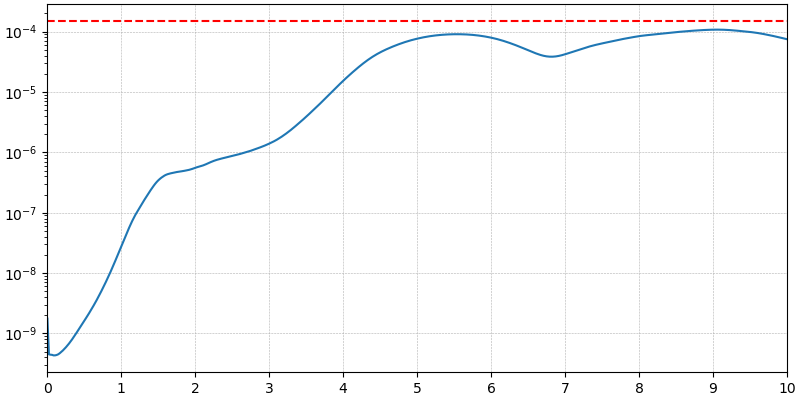

In [26]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)
H  = 60
Lf = 500
at_front = (dsf.xC >= 2e3-Lf) & (dsf.xC <= 2e3+Lf)
mup2 = dsf.up2.where(at_front).mean('xC')/150
dbdx = 1/np.cosh(2 * (dsf.xC + 2e3) / Lf)**2 - 1/np.cosh(2 * (dsf.xC - 2e3) / Lf)**2
mM2 = np.abs(dbdx).where(at_front).mean('xC')*dsf.attrs['M²']

plt.plot(dsf.day, mup2)
plt.axhline((mM2/1e-4*H)**2 / 2, ls='--', c='r')
plt.grid(ls='--', lw=0.4)
plt.yscale('log')
plt.xticks(np.linspace(0,10,11))
plt.xlim(0, 10);

In [3]:
def G(z, c, dH):
    return (np.tanh(c * (z + H + dH) / H) + 1) / 2

def iG(z, c, dH):
    return (z + H/c *np.log( np.cosh(c*(z+H+dH)/H) ) ) / 2

def b_horizontal(x, Lp, Lf):
    return (np.tanh( 2 * (x + Lp) / Lf ) - np.tanh( 2 * (x - Lp) / Lf )) * Lf / 2

def b_vertical(z, Nsq0, Nsq1):
    return Nsq1 * (z + 150) + (Nsq0 - Nsq1) * np.maximum(z + H, 0)

H = 60

In [125]:
bsep = np.floor((90*dsf.attrs['N₁²'] + 0) * 1e6) / 1e2
bsrf = np.floor((60*dsf.attrs['N₀²'] + dsf.Lf*dsf.attrs['M²'])     * 1e6) / 1e2 + bsep
nlev0, nlev1 = 10, 20
delb0 = np.floor((bsrf - bsep)/nlev0 * 1e2) / 1e2
# delb1 = np.floor((bsep - 0   )/nlev1 * 1e2) / 1e2 # 0.03 * (dsf.attrs['M²']/3e-8)**2
blines_upper = np.arange(bsep, bsrf, delb0)*1e-4
blines_lower = np.arange(0,    bsep, delb0)*1e-4
# blines_lower = np.linspace(0, bsrf, 60)*1e-4

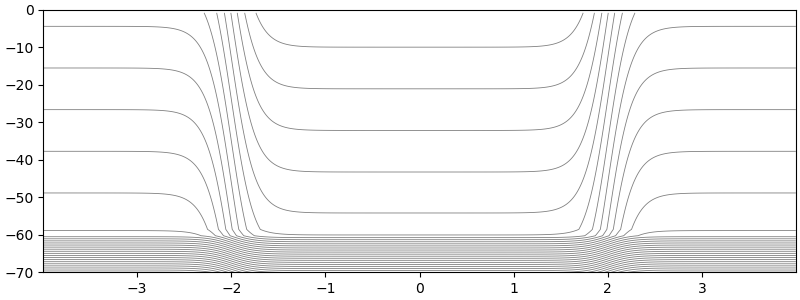

In [197]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)

# plt.contour(dsf.xC/1e3, dsf.zC, 
#             b_vertical(dsf.zC, dsf.attrs['N₀²'], dsf.attrs['N₁²']) + dsf.attrs['M²'] * (b_horizontal(dsf.xC, 2e3, 500) * G(dsf.zC, 3, 30)).T,
#             blines_upper, colors='k', linewidths=0.6)
# plt.contour(dsf.xC/1e3, dsf.zC, 
#             b_vertical(dsf.zC, dsf.attrs['N₀²'], dsf.attrs['N₁²']) + dsf.attrs['M²'] * (b_horizontal(dsf.xC, 2e3, 500) * G(dsf.zC, 3, 30)).T,
#             blines_lower, colors='gray', linewidths=0.6)

plt.contour(dsf.xC/1e3, dsf.zC, 
            b_vertical(dsf.zC, dsf.attrs['N₀²']*(2/3)**2 , dsf.attrs['N₁²']*(2/3)**2 / 4*2) + dsf.attrs['M²']*2/3 * (b_horizontal(dsf.xC, 2e3, 500) * G(dsf.zC, 5, 30)).T,
            205, colors='gray', linewidths=0.6)

plt.ylim(-70, 0);

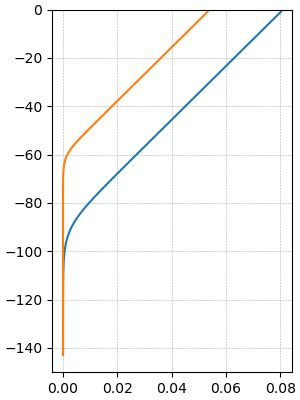

In [196]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

# plt.plot(b_vertical(dsf.zC, 8.1e-7, 8.1e-7*40), dsf.zC)

# plt.plot(G(dsf.zC, 6, 30), dsf.zC)
# plt.plot(G(dsf.zC, 12, 0), dsf.zC)
plt.plot(dsf.attrs['M²'] / dsf.f * ( iG(dsf.zC, 6, 30) - iG(-150, 6, 30) ), dsf.zC)
plt.plot(dsf.attrs['M²'] / dsf.f * ( iG(dsf.zC, 12, 0) - iG(-150, 12, 0) ), dsf.zC)

plt.grid(ls='--', lw=0.4)
plt.ylim(-150, 0);

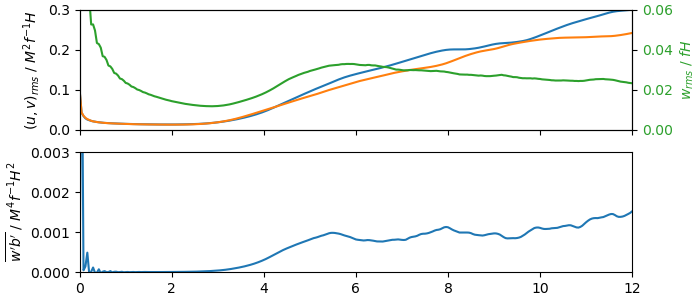

In [24]:
plt.close()
_,ax = plt.subplots(2,1, figsize=(7,3), constrained_layout=True, sharex=True)
# mwbt = dsf.wbt.where(at_front).mean('xC')

ax[0].plot(dsf.timeTf*(2*np.pi/1e-4/3600/24), np.sqrt(dsf.up2.mean('xC')/60) / (3e-8*60/1e-4))
ax[0].plot(dsf.timeTf*(2*np.pi/1e-4/3600/24), np.sqrt(dsf.vp2.mean('xC')/60) / (3e-8*60/1e-4))
ax[0].set_ylabel(r'$(u,v)_{rms}$ / $M^2 f^{-1} H$')
ax[0].set_ylim(0, 0.3)
ax0r = ax[0].twinx()
ax0r.tick_params(axis='y', labelcolor='C2')
ax0r.plot(dsf.timeTf*(2*np.pi/1e-4/3600/24), np.sqrt(dsf.wp2.mean('xC')/60) / (60*1e-4), color='C2')
ax0r.set_ylabel(r'$w_{rms}$ / $f H$', color='C2')
ax0r.set_ylim(0, 0.06)
# ax0r.fill_betweenx([0, 0.035], [8, 8],   [11, 11], color='gray', alpha=0.5, lw=0)
# ax0r.fill_betweenx([0, 0.035], [14, 14], [17, 17], color='C1',   alpha=0.5, lw=0)
# ax[0].grid(ls='--', lw=0.3)

ax[1].plot(dsf.timeTf*(2*np.pi/1e-4/3600/24), dsf.wbt.mean('xC')/60 / (3e-8**2*60**2/1e-4))
ax[1].set_ylabel(r"$\overline{w'b'}$ / $M^4 f^{-1} H^2$")
# ax[1].fill_betweenx([0, 0.13], [8, 8],   [11, 11], color='gray', alpha=0.5, lw=0)
# ax[1].fill_betweenx([0, 0.13], [14, 14], [17, 17], color='C1',   alpha=0.5, lw=0)
plt.xlim(0, 12)
ax[1].set_ylim(0, 0.003)
# plt.grid(ls='--', lw=0.3)
plt.xlabel('Day');

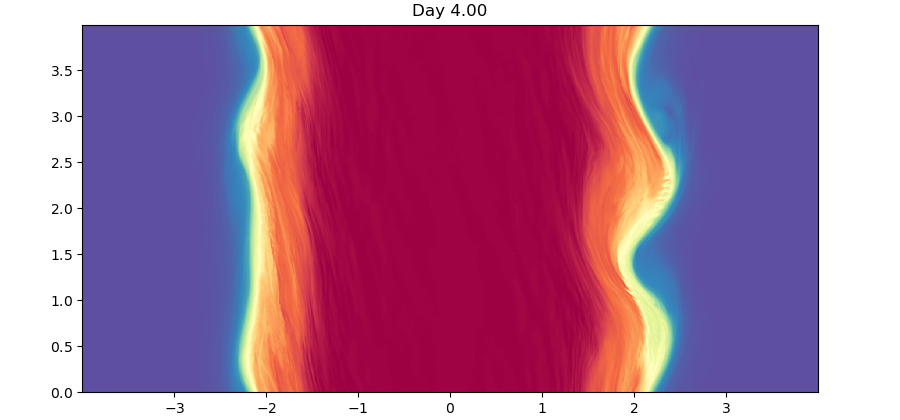

In [22]:
plt.close()
plt.figure(figsize=(9,4.2), constrained_layout=True)

itime = 24*2*4
# pcolor_lim(np.log10(dsf.c7.isel(time=itime,zC=0,xC=slice(1000,None)).clip(1e-4,1)).load(), plt.gca(), cmap='terrain_r', clim=[-4, 0])
pcolor_limits(dsf.b.isel(time=itime,zC=0).load(), plt.gca(), cmap='Spectral_r')#Blues_r
# pcolor_limits(dsf.b.isel(time=itime,zC=0,xC=slice(None,1000)).load(), plt.gca(), cmap='Spectral_r')
 
# pcolor_center(dsf.w.isel(time=itime,zC=0,xC=slice(1000,None)).load(), plt.gca(), cmap='binary_r')

# vm = dsf.v.isel(time=itime,zC=0,xC=slice(1000,None)).mean('yC')
# pcm,_ = pcolor_center((dsf.v.isel(time=itime,zC=0,xC=slice(1000,None)) - vm).load(), plt.gca(), cmap='RdBu_r')
# plt.colorbar(pcm, shrink=0.7)

daynum = dsf.time[itime].data/np.timedelta64(1, 'D')
plt.title(f'Day {daynum:.2f}')
plt.gca().set_aspect('equal');

In [37]:
b = 1e-5*dsf.zC + 1e-7*100/2*np.tanh(2*dsf.xC/100)
# c1 = np.sin(2*np.pi * ( 1e-5/1e-7*100/2*(np.sinh(4*dsf.xC/100)/4 + dsf.xC/100) - dsf.zC ) )
# c2 = np.sin(np.pi * ( dsf.zC/1 + 1e-7*100/2/1e-5/1*np.tanh(2*dsf.xC/100) ) )

c1 = np.sin(1*np.pi * (dsf.xC/1000 - dsf.zC/(1e-5*1000/1e-7/0.33)) )
c2 = np.sin(1*np.pi * (dsf.zC/1 + dsf.xC/(1*1e-5/1e-7/0.33)) )

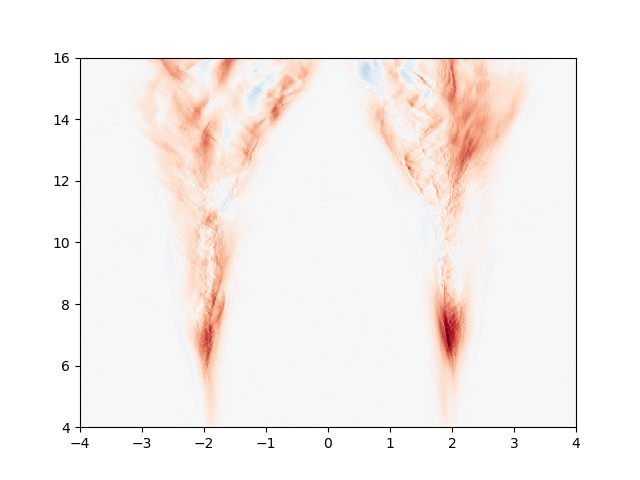

In [80]:
plt.close()

plt.figure()
plt.pcolormesh(dsf.xC, dsf.timeTf*(2*np.pi/1e-4/3600/24), dsf.wbt, vmin=-3e-8, vmax=3e-8, cmap='RdBu_r')
plt.ylim(4, 16);

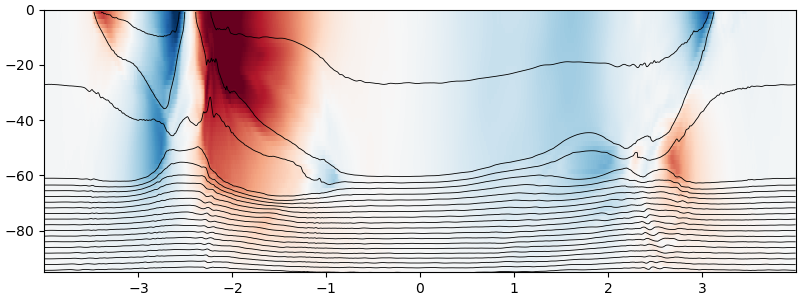

In [5]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)

itime = 24*2*7
# plt.pcolormesh(dsf.xC, dsf.zC, dsf.b.isel(time=itime).mean('yC'))
# plt.contour(dsf.xC, dsf.zC, dsf.b.isel(time=0).mean('yC'), np.linspace(1.11e-5, 1.83e-4, 31), linestyles='-', colors='gray', linewidths=0.8)
# plt.contour(dsf.xC, dsf.zC, dsf.b.isel(time=itime).mean('yC'), np.linspace(1.11e-5, 1.83e-4, 31), colors='k')

pcolor_center(dsf.v.isel(time=itime, yC=0))
plt.contour(dsf.xC/1e3, dsf.zC, dsf.b.isel(time=itime, yC=0), 60, linestyles='-', colors='k', linewidths=0.6)

plt.ylim(-95, 0);
# plt.gca().set_aspect('equal');

In [17]:
stream([(dsf.b.isel(zC=-1,time=i),
         dsf.b.isel(zC=-1,time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xy,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       # renderer_kwargs=dict(vmin=-4e-6, vmax=9e-6, cmap='RdBu_r')).write(cname+'_b_xy10.mp4');
       # renderer_kwargs=dict(vmin=5e-3, vmax=1.5e-2, cmap='RdBu_r')).write(cname+'_b_xy10.mp4');
       renderer_kwargs=dict(vmin=9e-3, vmax=1e-2, cmap='RdBu_r')).write(cname+'_b_xy10.mp4');

/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41055 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41055/status,
Dashboard: http://127.0.0.1:41055/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37145,Workers: 4
Dashboard: http://127.0.0.1:41055/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:40551,Total threads: 1
Dashboard: http://127.0.0.1:36405/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:45771,


/glade/derecho/scratch/zhihuaz/tmp/ipykernel_35031/2537028932.py:34: RuntimeWarning: More than 100 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
[SUCCESS] 01:23PM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/TracerInversion/Animations/c11_M001_Q000_W000_D000_St0_Ri1000_b_xy10.mp4.
[WARNING] 01:23PM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [23]:
stream([(dsf.b.isel(yC=350,time=i),
         dsf.b.isel(yC=350,time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xz,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=1.2e-4, vmax=1.8e-4, cmap='RdBu_r')).write(cname+f'_b_xzm.mp4'); # RiB=1
       # renderer_kwargs=dict(vmin=-4.8e-3, vmax=1.7e-2, cmap='RdBu_r')).write(cname+f'_b_xzm.mp4');
       # renderer_kwargs=dict(vmin=1.5e-4, vmax=9.85e-3, cmap='RdBu_r')).write(cname+f'_b_xzm.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42063,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:36161,Total threads: 1
Dashboard: http://127.0.0.1:39111/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:36415,


[SUCCESS] 07:03PM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/TracerInversion/Animations/c11_M003_Q000_W000_D000_St0_Ri1_b_xzm.mp4.
[WARNING] 07:03PM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [8]:
tr = 3
stream([(dsf[f'c{tr}'].isel(zC=-1,time=i),
         dsf.b.isel(zC=-1,time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xy,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu_r')).write(cname+f'_c{tr}_xy10.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41503,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: 2 minutes ago,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:41903,Total threads: 1
Dashboard: http://127.0.0.1:34865/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:38385,


[SUCCESS] 02:59PM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/TracerInversion/Animations/c11_M001_Q000_W000_D000_St0_Ri1000_c3_xy10.mp4.
[WARNING] 02:59PM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [ ]:
tr = 4
stream([(dsf[f'c{tr}'].isel(yC=0,time=i),
         dsf.b.isel(yC=0,time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xz,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu_r')).write(cname+f'_c{tr}_xzm.mp4');

In [15]:
var = 'v'
varsel = [var, 'b']
depth = 5
top = dsf[varsel].sel(zC=-depth, method='nearest')
south = dsf[varsel].isel(yC=0).sel(zC=slice(None,top.zC))
east = dsf[varsel].isel(xC=-1).sel(zC=slice(None,top.zC))

top['b']   = top.b   - dsf.attrs['M²']*top.xC
south['b'] = south.b - dsf.attrs['M²']*south.xC
east['b']  = east.b  - dsf.attrs['M²']*east.xC

In [21]:
if var == 'q':
    cmap = 'RdBu_r'
    cticks = np.arange(-2e-10,3e-10,1e-10)
    clabel_pad = -50
    vmin, vmax = -2.5e-10, 2.5e-10
    var_label = r'Ertel PV s$^{-3}$]'
    extend = 'both'
    sci_notation = True
elif var == 'b':
    colorlist = ['xkcd:navy', 'xkcd:cerulean', 'xkcd:sky', 'xkcd:white', 'xkcd:coral', 'xkcd:deep red']
    nodes = [0.0, 0.72, 0.84, 0.86, 0.88, 1.0]
    # colorlist = ['xkcd:navy', 'xkcd:cerulean blue', 'xkcd:white', 'xkcd:turquoise blue', 
    #              'xkcd:white', 'xkcd:kelly green', 'xkcd:white', 'xkcd:marigold',
    #              'xkcd:white', 'xkcd:grapefruit', 'xkcd:white', 'xkcd:reddish purple']
    # nodes = [0.0, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
    cmap = LinearSegmentedColormap.from_list('buoyancy', list(zip(nodes, colorlist)))
    # cmap = 'prism'#'gist_ncar'
    cticks = np.arange(0,1.8,0.2)*1e-3
    cticks_nsd = 1
    clabel_pad = -32
    vmin, vmax = 0, 1.69e-3
    var_label = r'Buoyancy [m s$^{-2}$]'
    extend = 'max'
    sci_notation = True
elif var == 'c':
    # top['logc']   =   np.log10(top.c.clip(1e-6,1)).squeeze().transpose('yC','xC',...)
    # south['logc'] = np.log10(south.c.clip(1e-6,1)).squeeze().transpose('xC','zC',...)
    # east['logc']  =  np.log10(east.c.clip(1e-6,1)).squeeze().transpose('yC','zC',...)
    cmap = 'ocean_r'
    cticks = np.arange(0,1.2,0.2)#np.arange(-2,0.5,0.5)
    clabel_pad = -42#-50
    vmin, vmax = 0, 1#-2, 0
    var_label = 'Tracer concentration'#r'$\log_{10}(c)$'
    extend = 'max'#'min'
    sci_notation = False
elif var == 'u':
    cmap = 'RdBu_r'
    # cticks = np.arange(-0.04,0.05,0.02)
    # vmin, vmax = -0.04, 0.04
    cticks = np.arange(-0.1,0.2,0.1)
    vmin, vmax = -0.1, 0.1
    cticks_nsd = 0
    clabel_pad = -31
    var_label = r'u [m s$^{-1}$]'
    extend = 'both'
    sci_notation = True
elif var == 'v':
    cmap = 'RdBu_r'
    # cticks = np.arange(-0.08,0.09,0.02)
    # vmin, vmax = -0.08, 0.08
    cticks = np.arange(-0.1,0.19,0.1)
    vmin, vmax = -0.1, 0.1
    cticks_nsd = 0
    clabel_pad = -31
    var_label = r'v [m s$^{-1}$]'
    extend = 'both'
    sci_notation = True
elif var == 'eps':
    cmap = 'Reds'
    cticks = np.arange(-9,-6,1)
    clabel_pad = -50
    vmin, vmax = -9, -7
    var_label = r'Dissipation rate $\log_{10}(\epsilon)$'
    extend = 'min'
    sci_notation = False
    # var_plt = 'logeps'

plt_kwargs = dict(var=var, cmap=cmap, cticks=cticks, cticks_nsd=cticks_nsd, clabel_pad=clabel_pad,
                vmin=vmin, vmax=vmax, var_label=var_label, extend=extend,
                sci_notation=sci_notation,
                levels=np.linspace(vmin, vmax, 256))

In [7]:
USER = os.getenv('USER')
TMPDIR = f'/glade/derecho/scratch/{USER}/temp'
job_script_prologue = ['export TMPDIR=/glade/scratch/derecho/$USER/temp', 'mkdir -p $TMPDIR']
cluster_kw = dict(job_name=cname+'_anim3d',
                  cores=1,
                  memory='6GiB',
                  processes=1,
                  local_directory=f'{TMPDIR}/pbs.$PBS_JOBID/dask/spill',
                  log_directory=f'{TMPDIR}/pbs.$PBS_JOBID/dask/worker_logs',
                  job_extra_directives=['-j oe'],
                  job_script_prologue=job_script_prologue,
                  resource_spec='select=1:ncpus=1:mem=6GB',
                  queue='casper',
                  walltime='30:00',
                  interface='ext')
cluster =  PBSCluster(**cluster_kw)
client = Client(cluster)
print(cluster.job_script())
cluster.scale(8)
# print(cluster.dashboard_link.replace(':8787', ':1212/proxy/42843'))

#!/usr/bin/env bash

#PBS -N s11_M009_Q000_W147_D270_St0_anim3d
#PBS -q casper
#PBS -A UMCP0020
#PBS -l select=1:ncpus=1:mem=6GB
#PBS -l walltime=30:00
#PBS -e /glade/derecho/scratch/zhihuaz/temp/pbs.$PBS_JOBID/dask/worker_logs/
#PBS -o /glade/derecho/scratch/zhihuaz/temp/pbs.$PBS_JOBID/dask/worker_logs/
#PBS -j oe
export TMPDIR=/glade/scratch/derecho/$USER/temp
mkdir -p $TMPDIR
/glade/work/zhihuaz/conda-envs/trace-seas/bin/python -m distributed.cli.dask_worker tcp://128.117.208.67:36569 --name dummy-name --nthreads 1 --memory-limit 6.00GiB --nanny --death-timeout 60 --local-directory /glade/derecho/scratch/zhihuaz/temp/pbs.$PBS_JOBID/dask/spill --interface ext



In [ ]:
%%time
# with dask.config.set({'distributed.nanny.pre-spawn-environ.MALLOC_TRIM_THRESHOLD_': 0}):
# with LocalCluster() as cluster, Client(cluster) as client:
stream([(top.isel(time=i), south.isel(time=i), east.isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xyz3d,
       max_frames=-1, renderer_iterables=[dsf.timeTf.data],
       renderer_kwargs=plt_kwargs,
       client=client,
       write_kwargs=dict(crf='18'),
       uri=cname+f'_{var}xyz{depth:02d}.mp4');

In [23]:
cluster.close()

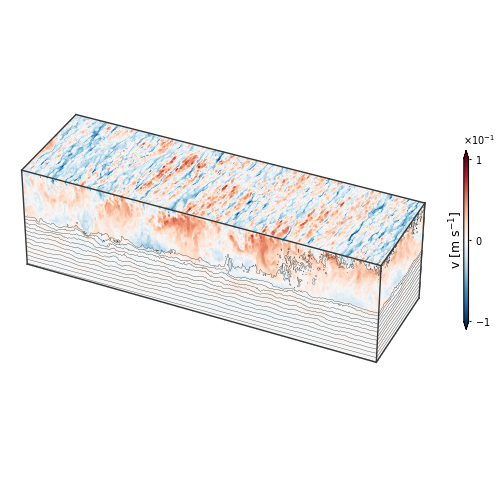

In [25]:
# i = 0
i = 209
fig = plot_xyz3d((top.isel(time=i), south.isel(time=i), east.isel(time=i)),
                 dsf.timeTf.data[i], **plt_kwargs);
# plt.savefig('../Figures/model_domain', dpi=600)
# plt.savefig('../Figures/'+cname+'_snapshot_v', dpi=600)

In [ ]:
cname = 'f11_Q000_W037_D180_St0'
dsf = xr.open_dataset('/glade/derecho/scratch/zhihuaz/FrontalZone/Output/'+cname+'_full.nc').chunk({'time':1, 'zC':32})
dsf.close()

In [14]:
%%time
with LocalCluster() as cluster, Client(cluster) as client:
    display(client)
    clist = ['f11_Q000_W000_D000_St0',
             'f11_Q000_W009_D000_St0',
             'f11_Q000_W009_D090_St0',
             'f11_Q000_W009_D180_St0',
             'f11_Q000_W009_D270_St0',
             'n11_Q000_W009_D000_St0']
    dsb = []
    for cname in clist:
        dsf = xr.open_dataset('/glade/derecho/scratch/zhihuaz/FrontalZone/Output/'+cname+'_full.nc').chunk({'time':1,'zC':32})
        dsf.close()
        dsf['timeTf'] = dsf.time/np.timedelta64(int(np.around(2*np.pi/dsf.f)), 's')
        dsb.append(xr.map_blocks(get_layer_mean, dsf.c).compute().rename('cml'))
    dsb = xr.concat(dsb, pd.Index(clist, name='case'))
# client.shutdown()
# client.close()

/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34585 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34585/status,
Dashboard: http://127.0.0.1:34585/status,Workers: 8
Total threads: 32,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45627,Workers: 8
Dashboard: http://127.0.0.1:34585/status,Total threads: 32
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:45981,Total threads: 4
Dashboard: http://127.0.0.1:46057/status,Memory: 2.50 GiB
Nanny: tcp://127.0.0.1:45247,


CPU times: user 15.8 s, sys: 1.67 s, total: 17.5 s
Wall time: 1min 52s


In [15]:
dsb['timeTf'] = dsb.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
dsb = dsb.swap_dims({'time': 'timeTf'})
dsb

<xarray.DataArray 'cml' (case: 6, timeTf: 316)> Size: 15kB
array([[           nan, 1.06141182e-04, 1.11587833e-04, ...,
        9.99167768e-02, 9.98134574e-02, 9.97055234e-02],
       [           nan, 1.06141182e-04, 1.11587833e-04, ...,
        9.11144772e-02, 9.13177800e-02, 9.14968622e-02],
       [           nan, 1.06141182e-04, 1.11587833e-04, ...,
        1.23345862e-01, 1.23451338e-01, 1.23561958e-01],
       [           nan, 1.06141182e-04, 1.11587833e-04, ...,
        1.33966424e-01, 1.34032714e-01, 1.34097661e-01],
       [           nan, 1.06141182e-04, 1.11587833e-04, ...,
        1.23030805e-01, 1.23360066e-01, 1.23711808e-01],
       [1.06009818e-04,            nan, 1.11575307e-04, ...,
        3.47126846e-03, 3.48890318e-03, 3.50658939e-03]])
Coordinates:
    time     (timeTf) timedelta64[ns] 3kB 4 days 08:44:08.194189526 ... 6 day...
  * case     (case) object 48B 'f11_Q000_W000_D000_St0' ... 'n11_Q000_W009_D0...
  * timeTf   (timeTf) float64 3kB 6.001 6.001 6.006 6.016 ... 8.976 8.986 8.995

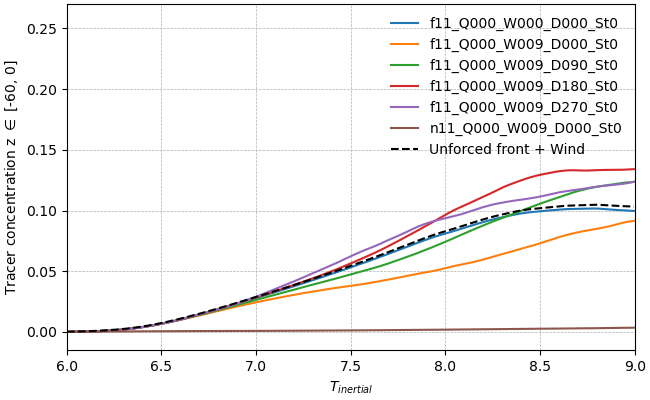

In [17]:
plt.close()
plt.figure(figsize=(6.5,4), constrained_layout=True)

dsb.plot.line(x='timeTf')
dsb.sel(case=['f11_Q000_W000_D000_St0','n11_Q000_W009_D000_St0']).sum('case').plot.line(x='timeTf',ls='--',color='k')
plt.grid('on', ls='--', lw=0.5)
plt.legend(dsb.case.data.tolist()+['Unforced front + Wind'], frameon=False)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel(r'Tracer concentration z $\in$ [-60, 0]')
plt.xlim(6,9)
plt.ylim(-0.015, 0.27);

In [17]:
stream([(dsf.u.mean('yC', keep_attrs=True).isel(time=i), dsf.b.mean('yC', keep_attrs=True).isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xc,#
       max_frames=-1, renderer_iterables=[dsf.timeTf.data],
       renderer_kwargs=dict(vmin=-1.3e-2, vmax=1.3e-2, cmap='RdBu_r', extend='both')).write(cname+'_uxz.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41111,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:33643,Total threads: 4
Dashboard: http://127.0.0.1:44317/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:41581,


[SUCCESS] 08:27PM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/Animations/f11_Q000_W037_D180_St0_uxz.mp4.


In [39]:
cname = 'f11_Q000_W037_D270_St0'
dsf = xr.open_dataset('/glade/derecho/scratch/zhihuaz/FrontalZone/Output/'+cname+'_full.nc'
                     ).chunk({'time':1})
dsf.close()
dsf['timeTf'] = dsf.time/np.timedelta64(int(np.around(2*np.pi/dsf.f)), 's')
u_slice = dsf.u.sel(yC=100, method='nearest')
w_slice = dsf.w.sel(yC=100, method='nearest')

periodic_coords = {dim : dict(left=f'{dim}F', center=f'{dim}C') for dim in 'xyz'}
bounded_coords = {dim : dict(outer=f'{dim}F', center=f'{dim}C') for dim in 'xyz'}
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('xyz', 'PPN')}
grid = Grid(dsf, coords=coords, periodic=['x', 'y'])
dzF = dsf.zF.diff('zF').data
dxF = dsf.xF.diff('xF').data[0]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    u_ccf = grid.interp(u_slice, axis='z', boundary='extend')
    w_fcc = grid.interp(w_slice, axis='x')
    omegay_slice = grid.diff(u_ccf, axis='z') / dzF[None,:,None] - grid.diff(w_fcc, axis='x') / dxF
    omegay_slice.attrs['long_name'] = 'vorticity in y'
    omegay_slice.attrs['units'] = r's$^{-1}$'

In [40]:
%%time
stream([(omegay_slice.isel(time=i), dsf.b.sel(yC=100, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xc,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       client=client,
       renderer_kwargs=dict(vmin=-3e-3, vmax=3e-3, cmap='RdBu_r', extend='both')).write(cname+'_omegaYxz100.mp4');

<Client: 'tcp://128.117.208.88:36541' processes=8 threads=8, memory=48.00 GiB>

[SUCCESS] 03:11PM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/Animations/f11_Q000_W037_D270_St0_omegaYxz100.mp4.


CPU times: user 1min 19s, sys: 4.82 s, total: 1min 24s
Wall time: 2min 27s


In [42]:
stream([(dsf.u.sel(yC=100, method='nearest').isel(time=i), dsf.b.sel(yC=100, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xc,
       max_frames=-1, 
       renderer_iterables=[dsf.timeTf.data],
       client=client,
       renderer_kwargs=dict(vmin=-1.3e-2, vmax=1.3e-2, cmap='RdBu_r', extend='both')).write(cname+'_uxz100.mp4');

<Client: 'tcp://128.117.208.88:41001' processes=8 threads=8, memory=48.00 GiB>

[SUCCESS] 11:30AM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/Animations/s11_Q000_W003_D270_St0_uxz100.mp4.
[WARNING] 11:30AM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [65]:
stream([(dsf.w.sel(yC=500, method='nearest').isel(time=i), dsf.b.sel(yC=500, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xc,#
       max_frames=-1, renderer_iterables=[dsf.timeTf.data],
       renderer_kwargs=dict(vmin=-3.3e-2, vmax=3.3e-2, cmap='RdBu_r', extend='both')).write(cname+'_wxz500.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38603,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: 1 hour ago,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:44833,Total threads: 4
Dashboard: http://127.0.0.1:35103/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:41741,


[SUCCESS] 10:52AM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/Animations/f11_Q000_W037_D270_St0_wxz500.mp4.


In [55]:
stream([(dsf.PV.mean('yF', keep_attrs=True).isel(time=i), dsf.b.mean('yC', keep_attrs=True).isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xc,#
       max_frames=-1, renderer_iterables=[dsf.timeTf.data],
       renderer_kwargs=dict(vmin=-2, vmax=2, cmap='RdBu_r', extend='both')).write(cname+'_PVxz.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38603,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: 1 hour ago,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:44833,Total threads: 4
Dashboard: http://127.0.0.1:35103/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:41741,


[SUCCESS] 10:15AM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/Animations/f11_Q000_W037_D270_St0_PVxc.mp4.
[WARNING] 10:15AM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [82]:
stream([(dsf.c.mean('yC', keep_attrs=True).isel(time=i), dsf.b.mean('yC', keep_attrs=True).isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xc,#
       max_frames=-1, renderer_iterables=[dsf.timeTf.data],
       renderer_kwargs=dict(vmin=0, vmax=1, cmap='ocean_r', extend='max')).write(cname+'_cxz.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38603,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: 3 hours ago,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:44833,Total threads: 4
Dashboard: http://127.0.0.1:35103/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:41741,


[SUCCESS] 12:11PM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/Animations/f11_Q000_W037_D180_St0_cxz.mp4.


In [83]:
stream([(dsf.c.sel(yC=500, method='nearest').isel(time=i), dsf.b.sel(yC=500, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xc,#
       max_frames=-1, renderer_iterables=[dsf.timeTf.data],
       renderer_kwargs=dict(vmin=0, vmax=1, cmap='ocean_r', extend='max')).write(cname+'_cxz500.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38603,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: 3 hours ago,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:44833,Total threads: 4
Dashboard: http://127.0.0.1:35103/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:41741,


[SUCCESS] 12:13PM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/Animations/f11_Q000_W037_D180_St0_cxz500.mp4.


In [7]:
stream([(dsf.v.sel(zC=-10/1e3, method='nearest').isel(time=i),
         dsf.v.sel(zC=-10/1e3, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xy,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=0, vmax=1, cmap='RdBu_r')).write(cname+'_vxy10.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 72
Total threads: 72,Total memory: 370.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35455,Workers: 72
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: 12 minutes ago,Total memory: 370.29 GiB
Comm: tcp://127.0.0.1:36885,Total threads: 1
Dashboard: http://127.0.0.1:35429/status,Memory: 5.14 GiB
Nanny: tcp://127.0.0.1:40515,


[SUCCESS] 03:51PM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/TracerInversion/Animations/c11_M010_Q000_W000_D000_St0_Ri10_vxy10.mp4.


In [ ]:
stream([(dsf.u.sel(zC=-60, method='nearest').isel(time=i), dsf.b.sel(zC=-60, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xy,
       max_frames=-1, renderer_iterables=[dsf.timeTf.data],
       renderer_kwargs=dict(vmin=-5.3e-2, vmax=5.3e-2, cmap='RdBu_r', extend='both')).write(cname+'_uxy10.mp4');

In [4]:
stream([(dsf.b.sel(zC=-10/1e3, method='nearest').isel(time=i),
         dsf.b.sel(zC=-10/1e3, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xy,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=4.9e-3, vmax=14.9e-3, cmap='RdBu_r')).write(cname+'_bxy10.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 72
Total threads: 72,Total memory: 370.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40197,Workers: 72
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: Just now,Total memory: 370.29 GiB
Comm: tcp://127.0.0.1:34323,Total threads: 1
Dashboard: http://127.0.0.1:38837/status,Memory: 5.14 GiB
Nanny: tcp://127.0.0.1:35457,


[SUCCESS] 09:14AM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/TracerInversion/Animations/c11_M010_Q000_W000_D000_St0_Ri10_bxy10.mp4.
[WARNING] 09:14AM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [4]:
tr = 4
stream([(dsf[f'c{tr}_ym'].isel(time=i),
         dsf.b_ym.isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xz,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu_r')).write(cname+f'_c{tr}ym_xz.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 72
Total threads: 72,Total memory: 370.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35865,Workers: 72
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: Just now,Total memory: 370.29 GiB
Comm: tcp://127.0.0.1:41985,Total threads: 1
Dashboard: http://127.0.0.1:36373/status,Memory: 5.14 GiB
Nanny: tcp://127.0.0.1:46823,


[SUCCESS] 09:02AM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/TracerInversion/Animations/c11_M010_Q000_W000_D000_St0_Ri10_c4ym_xz.mp4.
[WARNING] 09:02AM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [7]:
tr = 2
stream([(dsf[f'c{tr}'].sel(yC=750, method='nearest').isel(time=i),
         dsf.b.sel(yC=750, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xz,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu_r')).write(cname+f'_c{tr}_xzm.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 72
Total threads: 72,Total memory: 370.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46059,Workers: 72
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: 4 minutes ago,Total memory: 370.29 GiB
Comm: tcp://127.0.0.1:34809,Total threads: 1
Dashboard: http://127.0.0.1:44903/status,Memory: 5.14 GiB
Nanny: tcp://127.0.0.1:46383,


[SUCCESS] 10:24AM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/TracerInversion/Animations/c11_M010_Q000_W000_D000_St0_Ri10_c2_xzm.mp4.
[WARNING] 10:24AM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [6]:
tr = 2
stream([(dsf[f'c{tr}'].sel(zC=-500, method='nearest').isel(time=i),
         dsf.b.sel(zC=-500, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xy,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu_r')).write(cname+f'_c{tr}_xy10.mp4');

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 72
Total threads: 72,Total memory: 370.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41775,Workers: 72
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: 1 minute ago,Total memory: 370.29 GiB
Comm: tcp://127.0.0.1:33941,Total threads: 1
Dashboard: http://127.0.0.1:34619/status,Memory: 5.14 GiB
Nanny: tcp://127.0.0.1:43971,


[SUCCESS] 11:52AM: Saved stream to /glade/u/home/zhihuaz/Projects/TRACE-SEAS/TracerInversion/Animations/c11_M010_Q000_W000_D000_St0_Ri10_c2_xy10.mp4.
[WARNING] 11:52AM: The output displayed below could be an older, cached version; click the path above to view the latest.


In [ ]:
stream([(dsf.c3t.sel(zC=-10, method='nearest').isel(time=i),
         dsf.b.sel(zC=-10, method='nearest').isel(time=i)) for i in range(dsf.sizes['time'])],
       renderer=plot_xy,
       max_frames=-1,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
       threads_per_worker=1,
       renderer_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu_r', extend='both')).write(cname+'_c3_xy10.mp4');

In [19]:
resources = [(top.isel(time=i), south.isel(time=i), east.isel(time=i),) for i in range(300)]#top.sizes['time'])]

In [20]:
c3d = stream(resources, renderer=plot_3Dbox_surface,
              renderer_kwargs=dict(cname='f11_Q000_W000_D000_St0'),
              max_frames=-1)